# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# Reading data and pre-processing

In [3]:
# loading csv
df = pd.read_csv('data/final_dataset.csv')

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
df.columns

Index(['Unnamed: 0', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad',
       'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'Att.1', 'Succ', 'Match Report', 'Name', 'Season', 'Fls', 'Fld', 'Off',
       'Crs', 'TklW', 'OG', 'PKwon', 'PKcon', 'WDL', 'GoalsTeams',
       'Team Score', 'Opp Score', 'CS', 'Was Home', 'GW', 'neutral_name',
       'Total Points', 'FPL position', 'Opp rating', 'Team rating',
       'ScoreForLast5', 'ScoreAgainstLast5', 'Min_points', 'MinAvgOverall',
       'GlsAvgOverall', 'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall',
       'xGAvgOverall', 'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
       'Opp ScoreAvgOverall'],
      dtype='object')

In [5]:
# features = ["Was Home", "Team rating", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5', 
#         'MinAvgOverall', 'GlsAvgOverall',
#        'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
#        'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
#        'Opp ScoreAvgOverall']
# info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
# to_predict = ["Total Points"]



to_predict = ["Total Points"]
features1 = ["Was Home", "Team rating", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']
features2 = ["Min", 'Gls', 'Ast', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'xG', 'xAG', 'CS']
info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]

rolling_gameweeks = [2,4,30]
features = features1

for r in rolling_gameweeks:
    form_means = df.groupby(["Name"])[features2].rolling(r).mean().reset_index()
    form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
    features += form_means.columns.tolist()
    features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
    df = pd.concat([df, form_means], axis=1)

# form2_means = df.groupby(["Name"])[features2].rolling(2).mean().reset_index()
# form2_means.columns = [f'{col}{"_2"}' for col in form2_means.columns]

# form4_means = df.groupby(["Name"])[features2].rolling(4).mean().reset_index()
# form4_means.columns = [f'{col}{"_4"}' for col in form4_means.columns]

# features = features1 + form2_means.columns.tolist() + form4_means.columns.tolist()
# features = list(filter(lambda x: x not in ["Name_2", "Name_4"], features))

# df = pd.concat([df, form2_means, form4_means], axis=1)

In [6]:
df = df[np.unique(features + info + to_predict)]

In [7]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [8]:
(df["GW"] == "season").sum()

0

In [9]:
df.shape

(24599, 43)

In [10]:
# dropping NaNs
df = df.dropna(axis=0)

In [11]:
df.shape

(9923, 43)

In [12]:
# df[df["Name"] == "Mohamed-Salah"]

# Choosing features and splitting data

In [13]:
GAMEWEEK_TO_PREDICT = 27

In [14]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[(df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][features]
y_train = df[(df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][to_predict]

In [15]:
X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [16]:
X_train.size, X_test.size

(226138, 9044)

# Model

In [17]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        # log
        y = np.log1p(y)
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = gmean(model_preds, weights=self.weights)
        return np.expm1(preds)
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [18]:
lgbm = LGBMRegressor()
xgb = XGBRegressor()
gbr = GradientBoostingRegressor()

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [1,1,1]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

# model = HybridModel(models, names, weights)

In [19]:
model = GradientBoostingRegressor(random_state=42)
# model = RandomForestRegressor()

In [20]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 1.81 s
Wall time: 1.84 s


GradientBoostingRegressor(random_state=42)

In [21]:
# make predictions on the test data
predictions = model.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate the MAE and MSE scores
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [23]:
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  1.2699755094945326
MSE:  3.8943624886609736


# Predictions

In [24]:
df_predictions = df[df["GW"] == GAMEWEEK_TO_PREDICT]

In [25]:
df_predictions.shape

(238, 43)

In [26]:
len(predictions)

238

In [27]:
df_predictions.loc[:, "pred"] = predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

Boolean Series key will be reindexed to match DataFrame index.


array([6.870056])

In [29]:
preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)

In [30]:
preds.head(30)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
1039,Alexis-Mac-Allister,27,Brighton,Leeds United,0.0,1694.406006,7.0,9.480957
276,Abdoulaye-Doucoure,27,Everton,Brentford,1.0,1795.347290,5.0,9.230713
8528,Harry-Kane,27,Tottenham,Nott'ham Forest,1.0,1653.916626,13.0,8.997691
9654,Jack-Harrison,27,Leeds United,Brighton,1.0,1825.127197,11.0,7.338120
2083,Ben-Chilwell,27,Chelsea,Leicester City,0.0,1755.349365,8.0,7.105573
6466,Dwight-McNeil,27,Everton,Brentford,1.0,1795.347290,11.0,7.063673
17349,Mohamed-Salah,27,Liverpool,Bournemouth,0.0,1646.125122,0.0,6.870056
17126,Miguel-Almiron,27,Newcastle Utd,Wolves,1.0,1726.051636,9.0,6.738730
6663,Ederson,27,Manchester City,Crystal Palace,0.0,1741.190063,6.0,6.530678
5857,Demarai-Gray,27,Everton,Brentford,1.0,1795.347290,3.0,6.259308


In [31]:
preds[preds["Squad"] == "Manchester City"]

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
6663,Ederson,27,Manchester City,Crystal Palace,0.0,1741.190063,6.0,6.530678
2494,Bernardo-Silva,27,Manchester City,Crystal Palace,0.0,1741.190063,3.0,5.451500
19327,Phil-Foden,27,Manchester City,Crystal Palace,0.0,1741.190063,1.0,5.247840
20616,Rodri,27,Manchester City,Crystal Palace,0.0,1741.190063,3.0,5.178827
9583,Jack-Grealish,27,Manchester City,Crystal Palace,0.0,1741.190063,3.0,4.866220
9196,Ilkay-Gundogan,27,Manchester City,Crystal Palace,0.0,1741.190063,6.0,4.775382
20884,Ruben-Dias,27,Manchester City,Crystal Palace,0.0,1741.190063,5.0,4.489227
17865,Nathan-Ake,27,Manchester City,Crystal Palace,0.0,1741.190063,6.0,4.110824
13956,Kyle-Walker,27,Manchester City,Crystal Palace,0.0,1741.190063,1.0,2.177694
12246,John-Stones,27,Manchester City,Crystal Palace,0.0,1741.190063,9.0,2.154456


# Feature importance and influence

In [32]:
# plot_importance(model)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


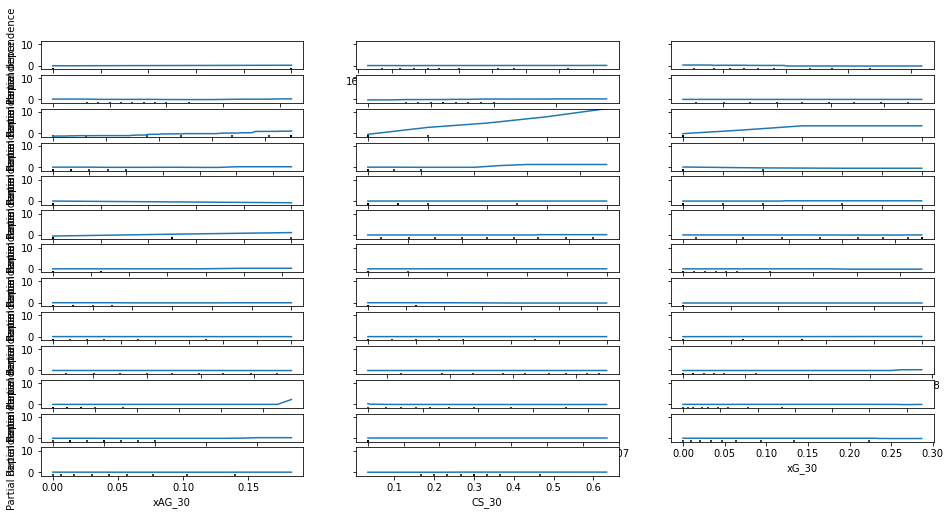

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model, X_train, features, ax=ax)

In [34]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

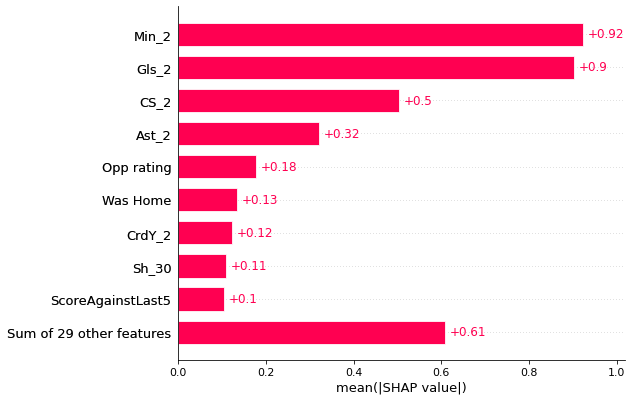

In [35]:
shap.plots.bar(shap_values)

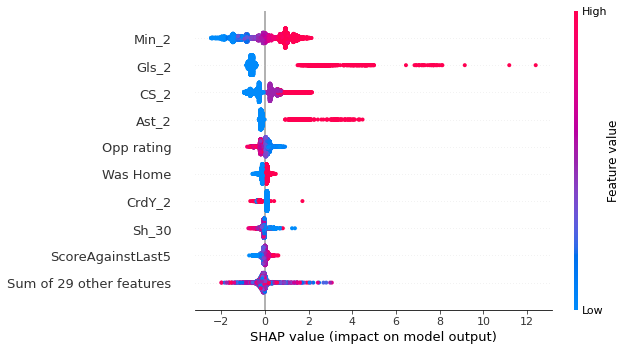

In [36]:
shap.plots.beeswarm(shap_values)

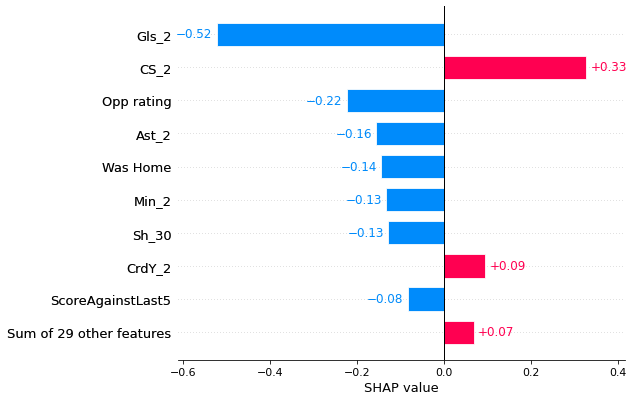

In [37]:
shap.plots.bar(shap_values[124])